### Proyecto 03 - Procesamiento del Lenguaje Natural

#### Dataset: The Multilingual Amazon Reviews Corpus


Implementare un modelo para reconocer el puntaje asignado a un ítem de Amazon a partir de la crítica que hace un/a usuario/a.

Link al repositorio: https://github.com/CaroDegiorgio/Acamica-Proyecto3

#### **Parte A - Exploración de Datos**


In [1]:
#Importo las librerías básicas y librerías específicas de NLP

import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cti22275\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cti22275\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#Lectura del dataset

amazon_df = pd.read_json('dataset_es_dev.json', lines= True)
amazon_df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


En el dataset se puede observar datos de identificación del producto, de la reseña y del cliente. 

Realizo una primera exploración de diferentes columnas para entender numéricamente como está compuesto el dataset y responderme las siguientes preguntas:

* Product_id: ¿Qué cantidad de productos están reseñados?
* Reviewer_id: ¿Qué cantidad de Usuarios únicos reseñan productos?
* Stars: Describo como se distribuye la variable mediante una descripción ('describe') ya que es la única variable numérica.
* Language: si hay un solo tipo de idioma elimino la columna porque es un dato reiterativo.
* Product_category: ¿Cuántas categorías hay reseñadas? ¿Cuáles son las que poseen mayor cantidad de reseñas? ¿Hay categorías que acumulen más reseñas de un tipo específico (negativas, positivas, neutras)?

In [3]:
#El dataset tiene 5000 instancias totales y 8 columnas.

amazon_df.shape

(5000, 8)

In [4]:
#No posee valores faltantes
print(amazon_df.isna().sum(axis=0))

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64


In [5]:
#Product_id --> Length: 4964: es decir la mayoría de los productos tienen una reseña única.
amazon_df['product_id'].value_counts()

product_es_0871533    2
product_es_0589001    2
product_es_0287441    2
product_es_0617074    2
product_es_0877622    2
                     ..
product_es_0529695    1
product_es_0070976    1
product_es_0572037    1
product_es_0372832    1
product_es_0380539    1
Name: product_id, Length: 4964, dtype: int64

In [6]:
#Reviewer_id --> Length: 4982: salvo excepciones mínimas las reseñas son de diferentes clientes.
amazon_df['reviewer_id'].value_counts()

reviewer_es_0217679    2
reviewer_es_0484716    2
reviewer_es_0039406    2
reviewer_es_0676987    2
reviewer_es_0865785    2
                      ..
reviewer_es_0349067    1
reviewer_es_0502396    1
reviewer_es_0095070    1
reviewer_es_0644896    1
reviewer_es_0690328    1
Name: reviewer_id, Length: 4982, dtype: int64

La proporción de usuarios que reseñan y productos reseñados es prácticamente de un usuario por producto. Es decir que el criterio de clasificar los usuarios o los productos resultaría innecesario. 

In [7]:
#Realizo una descripción del único dato numérico que posee el dataset, la calificación, en la columna 'stars'
amazon_df.describe()

,stars
count,5000.000000
mean,3.000000
std,1.414355
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


Si bien es necesario ahondar en cómo están correlacionadas las variables puede existir un warning en que el promedio
de clasificaciones es 3 (3/5) por lo que puede concentrarse en una valoración neutra y ser difícil de predecir (por no estar en los extremos). Este es un problema común en las calificaciones, por eso existen alternativas como el NPS (Net Promote Score) que en su cálculo disminuyen la influencia de estos clientes pasivos o neutrales. Más adelante retomaré este concepto. 

Respecto a las calificaciones intento averiguar si hay una preminencia de reviews negativas sobre las positivas o neutras mediante un gráfico de torta.

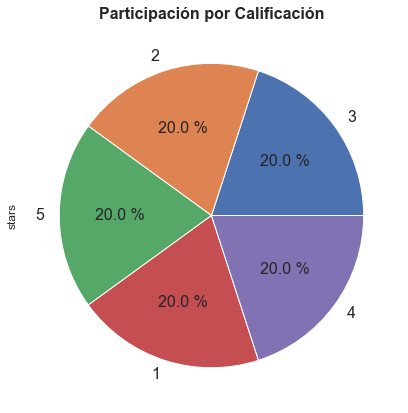

In [8]:
ax = amazon_df.stars.value_counts().plot.pie(autopct='%.1f %%',
                                               figsize=(15, 7), fontsize=16)
ax.set_title("Participación por Calificación",
             fontsize=16, weight="bold")
plt.show()

El dataset se encuentra dividido de manera equilibrada entre cada calificación existente. Con esta primera exploración mantengo la idea que un modelo clasificador puede resultar confuso, sobre todo en las calificaciones medias (2, 3, 4). 

In [9]:
#Language: Trae un solo tipo de variable por lo que eliminaré la columna
amazon_df['language'].value_counts()

es    5000
Name: language, dtype: int64

Analizo si hay categorías de productos más reseñadas, a fin de evaluar si tratarlos como outliers o por el contrario hacer foco en su diferencia. 

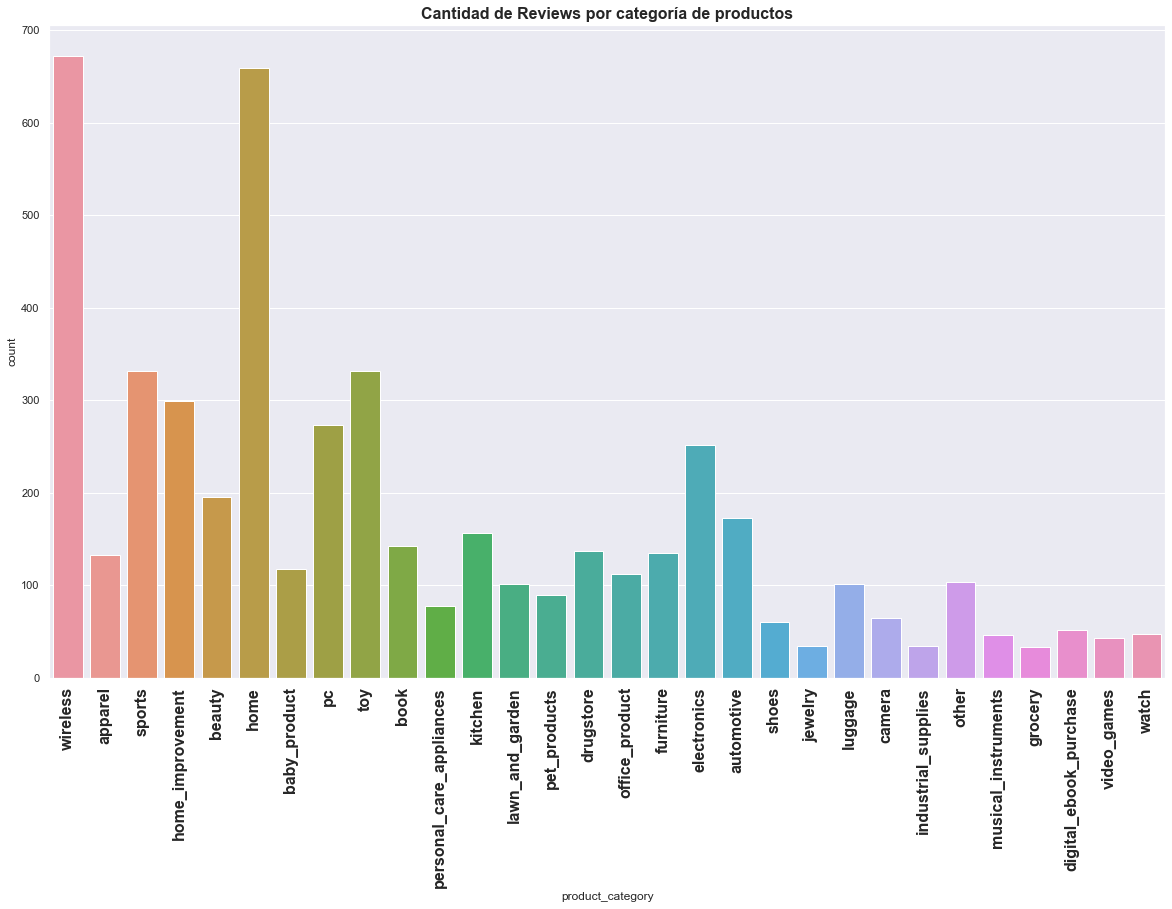

In [10]:
#Product Category

plt.figure(figsize=(20,12))
sns.set_palette("husl", 8)
sns.countplot(data = amazon_df, x = "product_category").set_title('Cantidad de Reviews por categoría de productos',
             fontsize=16, weight="bold")
plt.xticks(rotation = 90, fontsize=16, weight="bold")

plt.show()

También analizo como participan las calificaciones dentro de cada una de esas categorías, reafirmando lo que intuía en los análisis previos: las calificaciones de casi todas las categorías se acomodan entre el 2 y el 4 (no usan los puntajes extremos). 
En esta instancia pienso en si es necesario tomar las calificaciones extremas (1 y 5) como outliers y rearmar la escala para el entrenamiento de modelos, o generar algún clasificador que agrupe algunas de las calificaciones medias a sus extremos (el 2 igualarlo al 1, o el 4 al 5 en su tratamiento, para disminuir la presencia de calificaciones neutras).

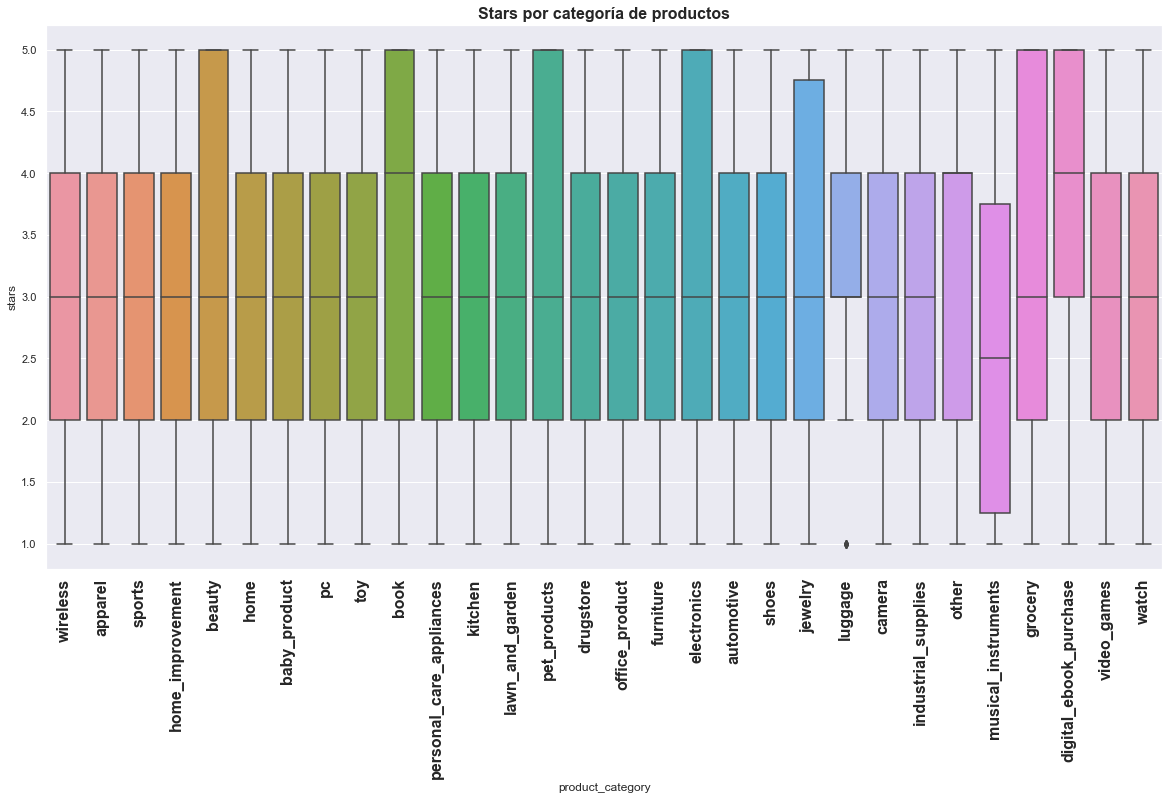

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.boxplot(x='product_category', y='stars', data=amazon_df)
ax.set_title('Stars por categoría de productos',
             fontsize=16, weight="bold")
plt.xticks(rotation = 90, fontsize=16, weight="bold")
plt.show()

Borro las columnas que no serán relevantes para las clasificaciones o predicciones según las conclusiones a las que arribo en el EDA.

In [12]:
amazon_df.drop(['language', 'review_id', 'product_id', 'reviewer_id'], 
               axis=1, inplace = True)

# <span style="color:turquoise"> Preprocesamiento de NLP </span>

Comienzo a aplicar herramientas de NLP, en principio con una óptica EDA (Exploratory Data Analysis), tratando de entender como se estructuran los datos lingüísticos. 

### Stopwords

Importo los stopwords en español.

Se trata de un corpus de términos que incluye palabras demasiado usuales y poco informativas desde el punto de vista léxico, tales como conjunciones (y, o, ni, que), preposiciones (a, en, para, por, entre otras) y verbos muy comunes (ser, ir, y otros más).

In [13]:
stopwords_amazon = nltk.corpus.stopwords.words('spanish')
stopwords_amazon = [palabra for palabra in stopwords_amazon if 'not' not in palabra]
#stopwords_amazon

In [14]:
#Genero una lista de términos que puedo encontrar y quiero filtrar manualmente ya que no están en los stopwords. En general son términos mal escritos o con errores
#de tipeo (poseen guiones, comas, espacios)

filtrar = []
if True:
    filtrar.append("el")
    filtrar.append("lo")
    filtrar.append("ma")
    filtrar.append("la")
    filtrar.append("'la")
    filtrar.append("'el")
    filtrar.append("'")
    filtrar.append("Que")
    filtrar.append("El")
    filtrar.append("La")
    filtrar.append("si")

### Tokenización

Tomo en primera instancia los Títulos de las reviews. 
Mi objetivo es ver si esa columna (review_title) genera información que enriquece la reseña o es solo un resumen de la misma, para disminuir el dataset a sus datos necesarios.
Realizo un for mediante el cual tokenizo (es decir deconstruyo la oración en términos individuales) y posteriormente filtro de esa lista de palabras los stopwords.

In [15]:
review_title_amazon = []
for i in range(amazon_df.shape[0]):
    title_review = (amazon_df.iloc[i].review_title).lower()
    title_review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(title_review)
    title_review = [word for word in  title_review if word not in stopwords_amazon]
    title_review = [word for word in  title_review if word not in filtrar]

    review_title_amazon.append(title_review)

Convierto los términos tokenizados y filtrados sus stopwords en una cadena, para posteriormente analizar la frecuencia en la que aparecen en todo los títulos del dataset.  

In [16]:
review_title_amazon = list(itertools.chain(*review_title_amazon))
review_title_amazon[0:10]

['mala',
 'compra',
 'recibido',
 'aprieta',
 'bien',
 'manillar',
 'brocas',
 'mantequilla',
 'gusta',
 'bolas']

In [17]:
freq_title = nltk.FreqDist(review_title_amazon)
freq_title

FreqDist({'calidad': 401, 'bien': 309, 'buena': 237, 'precio': 230, 'producto': 190, 'buen': 189, 'mal': 108, 'mala': 104, 'perfecto': 102, 'bueno': 85, ...})

In [18]:
#Convierto el arreglo anterior en un dataset de pandas.

df_review_title = pd.DataFrame(list(freq_title.items()), columns = ["Palabra","Frecuencia"])
df_review_title = df_review_title.sort_values(by='Frecuencia', ascending=False)

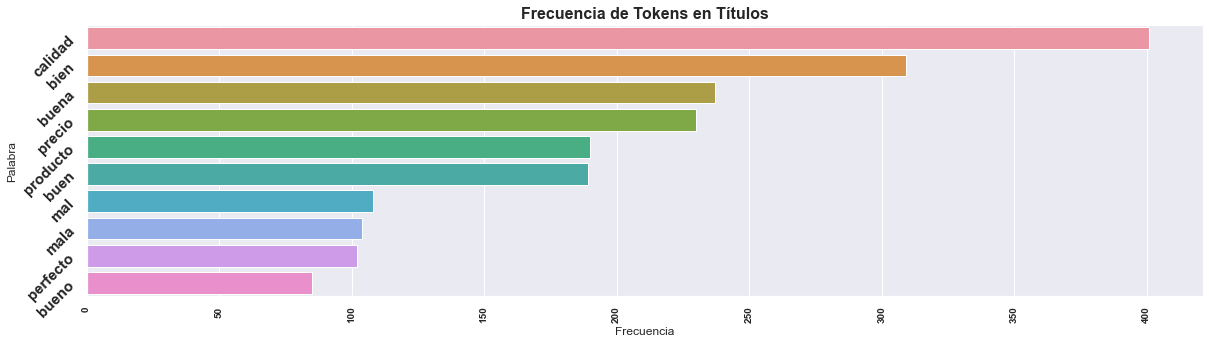

In [19]:
plt.figure(figsize=(20,5))
plt.grid(c='white')
plt.xticks(rotation = 90, fontsize=10, weight="bold")
plt.yticks(rotation = 45, fontsize=15, weight="bold")
sns.barplot(y = df_review_title['Palabra'], x = df_review_title['Frecuencia'], data=df_review_title, order= (df_review_title['Palabra'][:10])).set_title('Frecuencia de Tokens en Títulos',
             fontsize=16, weight="bold")
plt.show()

Grafico los resultados de Palabras Frecuentes en el Título de las reseñas. 
Se puede observar que las palabras más frecuentes son ambiguas respecto a lo positivo o negativo (a excepción de buena, bien, mal, mala por ejemplo) y demasiado generales.

In [20]:
review_body_amazon = []
for i in range(amazon_df.shape[0]):
    body_review = (amazon_df.iloc[i].review_body).lower()
    body_review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(body_review)
    body_review = [word for word in  body_review if word not in stopwords_amazon]
    body_review = [word for word in  body_review if word not in filtrar]

    review_body_amazon.append(body_review)

In [21]:
review_body_amazon = list(itertools.chain(*review_body_amazon))
review_body_amazon[0:10]

['malisimo',
 'grande',
 'demasiado',
 'aparatoso',
 'mal',
 'protector',
 'pantalla',
 'recibido',
 'pedido',
 'devolución']

In [22]:
freq_body = nltk.FreqDist(review_body_amazon)
freq_body

FreqDist({'bien': 1328, 'calidad': 788, 'producto': 605, 'precio': 583, 'buena': 461, 'bastante': 324, 'funciona': 282, 'buen': 274, 'dos': 247, 'mas': 247, ...})

In [23]:
df_review_body = pd.DataFrame(list(freq_body.items()), columns = ["Palabra_body","Frecuencia_body"])
df_review_body = df_review_body.sort_values(by='Frecuencia_body', ascending=False)

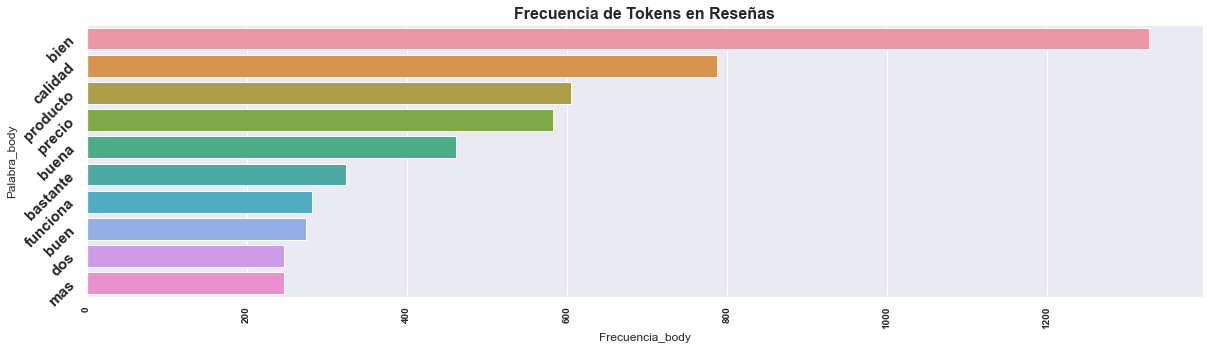

In [24]:
plt.figure(figsize=(20,5))
plt.grid(c='white')
plt.xticks(rotation = 90, fontsize=10, weight="bold")
plt.yticks(rotation = 45, fontsize=15, weight="bold")
sns.barplot(y = df_review_body['Palabra_body'], x = df_review_body['Frecuencia_body'], data=df_review_body, order= (df_review_body['Palabra_body'][:10])).set_title('Frecuencia de Tokens en Reseñas',
             fontsize=16, weight="bold")
plt.show()

Como conclusión el análisis de frecuencia de tokens no ofrece por si solo una guía respecto a la correlación entre palabras y estrellas (calificaciones). 

Sería posible realizar algunas agrupaciones (por categorías de productos, o por tipos de calificación, positivas o negativas, promotoras o detractoras), pero prefiero economizar esfuerzos y longitud del análisis y hacerlo cuando analice N-gramas. 

# <span style="color:turquoise"> N-gramas </span> 

Como el usuario está expresando su parecer frente a un producto, y sobre todo en el idioma castellano, en general no lo hará mediante términos individuales sino mediante frases. Es por eso que realizo una exploración de los N-gramas. 

Los mismos son secuencias lineales de unidades lingüísticas. En términos más sencillos, son grupos de palabras que se utilizan juntas en la revisión que realiza el usuario. Podemos analizar desde dos palabras (bigrams) en adelante. 

Yo realizaré una exploración de bigrams y trigrams, tanto en títulos como en el cuerpo de la review. 

Cargo la librería Re, que buscará expresiones regulares (regex), las mismas se definen como patrones de coincidencia de texto descritos con una sintaxis formal.

Por su parte Unicodedata normalizará el texto representándolo como puntos de código.

In [25]:
import re
import unicodedata

from unicodedata import normalize

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cti22275\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

###  Ngram Títulos 

En primer lugar realizo la identificación de los n-gramas en los textos de los títulos y cuerpo por separado (a los fines exploratorios). 

Realizo una función para limpiar el texto, es decir quitar stopwords y llevar todo el texto a minúsculas. 

La función definida también normaliza el texto en los estándares de Unicode, el cuál es una codificación de caracteres diseñado para facilitar el tratamiento informático, transmisión y visualización de textos de numerosos idiomas y disciplinas técnicas.

Otro aspecto de la normalización es llevar todas las palabras a minúscula (porque de lo contrario se tomaría una misma palabra escrita con mayúsculas totales o intermedias como datos diferentes). 

Además la función Lemmantiza, es decir lleva las palabras a una raíz común considerando su contexto y función en el texto. 

In [26]:
def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('spanish') 
  text = (unicodedata.normalize('NFD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
#Luego de varias pruebas donde las palabras con acento y ñ quedaban divididas en un nuevo token luego del caracter especial agregue la siguiente regularización.
  words = re.sub(r'([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+', r'\1, 0', text).split() 
  words = re.sub("[^a-zA-Z]"," ",text).split()  
  words = [word for word in words if word not in filtrar]
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [27]:
words = basic_clean(''.join(str(amazon_df['review_title'].tolist())))

In [28]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
bigrams_series

(calidad, precio)      133
(buen, producto)        72
(buena, calidad)        69
(mala, calidad)         66
(relacion, calidad)     63
(buena, compra)         41
(buena, relacion)       41
(buen, precio)          22
(precio, bien)          19
(merece, pena)          16
dtype: int64

In [29]:
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())
trigrams_series[:5]

(relacion, calidad, precio)    62
(buena, relacion, calidad)     37
(buena, calidad, precio)       11
(calidad, precio, buena)       10
(calidad, precio, bien)        10
dtype: int64

Luego de realizar la identificación de bigrams y trigrams más frecuentes en las reseñas, grafico el resultado.

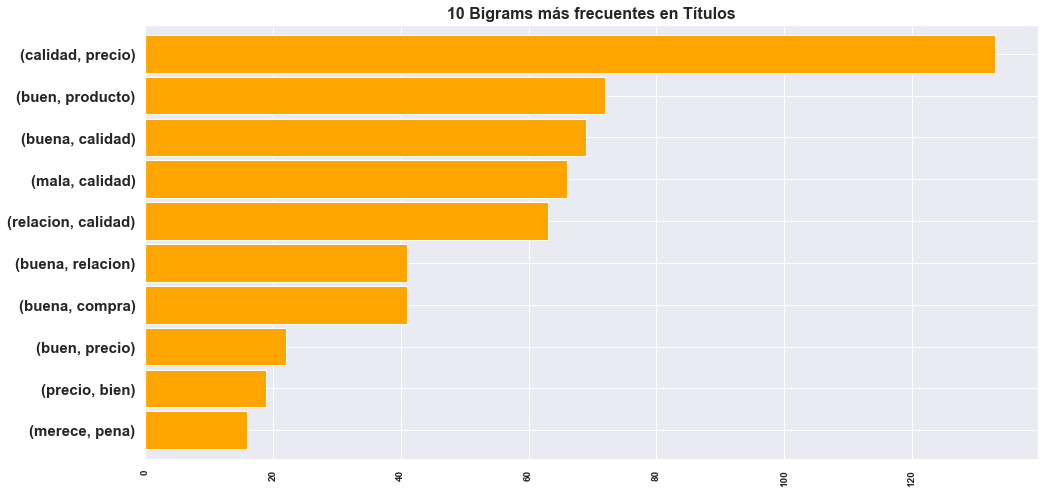

In [30]:
bigrams_series.sort_values().plot.barh(color='orange', width=.9, figsize=(16, 8))
plt.title('10 Bigrams más frecuentes en Títulos', fontsize=16, weight="bold")
plt.xticks(rotation = 90, fontsize=10, weight="bold")
plt.yticks(fontsize=15, weight="bold")
plt.show()

###  Ngram Body

Realizo el mismo análisis anterior, explorando los bigrams y trigrams en la descripción del cuerpo de las reviews.

In [31]:
words_body = basic_clean(''.join(str(amazon_df['review_body'].tolist())))

In [32]:
bigrams_series_body = (pd.Series(nltk.ngrams(words_body, 2)).value_counts())[:10]
bigrams_series_body

(calidad, precio)      194
(buena, calidad)       161
(relacion, calidad)    103
(funciona, bien)        86
(va, bien)              71
(buen, producto)        70
(cumple, funcion)       61
(mala, calidad)         51
(bastante, bien)        48
(queda, bien)           43
dtype: int64

In [33]:
trigrams_series_body = (pd.Series(nltk.ngrams(words_body, 3)).value_counts())
trigrams_series_body[:10]

(relacion, calidad, precio)         102
(buena, relacion, calidad)           35
(puede, pedir, ma)                   29
(precio, puede, pedir)               17
(calidad, precio, bien)              17
(buena, calidad, precio)             16
(calidad, precio, buena)             16
(parece, buena, calidad)             10
(cumple, perfectamente, funcion)      9
(bien, cumple, funcion)               7
dtype: int64

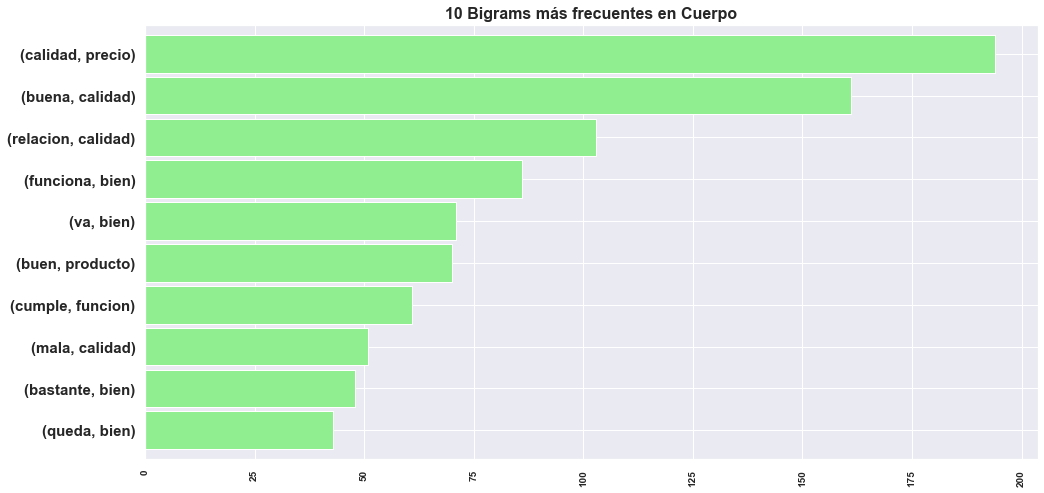

In [34]:
bigrams_series_body.sort_values().plot.barh(color='lightgreen', width=.9, figsize=(16, 8))
plt.title('10 Bigrams más frecuentes en Cuerpo', fontsize=16, weight="bold")
plt.xticks(rotation = 90, fontsize=10, weight="bold")
plt.yticks( fontsize=15, weight="bold")
plt.show()

Es posible ver que los términos más asociados en los n-gramas (calidad, precio, relación) se repiten en ambos conjuntos de datos (títulos y cuerpo), pero que en el cuerpo hay mayor riqueza de relación entre los términos conforme a su función en el texto (califican con adjetivos por ejemplo "buen producto" o "mala calidad").

Por eso voy a reformular el dataset trabajando solo con el cuerpo de las reviews. Además dividiendo los datos en menos grupos de calificación. 

In [35]:
amazon_df.drop(['review_title'],axis=1, inplace = True) #quito los datos relativos a los títulos

### Lemantización
Con la función anteriormente definida para regularizar y lemmantizar el texto, construyo una columna de datos de Bigrams de cada reseña.

La lemantización relaciona una palabra flexionada o derivada con su forma canónica o lema, o sea la forma que tienen las palabras cuando las buscamos en el diccionario.

In [36]:
lemm_list=[]
for review in amazon_df.review_body:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review=basic_clean(review)
    
    # Por ultimo volvemos a unir el titular
    review=" ".join(review)
    #dataset["titular_normalizado"] = titular_list
    lemm_list.append(review)

In [37]:
amazon_df["review_lemm"] = lemm_list
amazon_df.tail()

,stars,review_body,product_category,review_lemm
4995,5,Me ha encantado la cesta. Ha llegado impecable...,home,encantado cesta llegado impecable tamano util ...
4996,5,Desempeña su función correctamente,camera,desempena funcion correctamente
4997,5,Me ha encantado la diadema! Las flores son tal...,toy,encantado diadema flores tal vienen imagen ven...
4998,5,"A mi me gustan mucho las fundas TPU, ya que so...",wireless,gustan fundas tpu fundas normalmente finas col...
4999,5,El artículo ha cumplido con las expectativas q...,apparel,articulo cumplido expectativas deseaba


Como paso previo a vectorizar rearmo el dataset conservando solo los textos lemmantizados y la calificación.

In [38]:
amazon_lemm = pd.concat([amazon_df.review_lemm,amazon_df.stars],axis=1)
amazon_lemm.head()

,review_lemm,stars
0,malisimo grande demasiado aparatoso mal protec...,1
1,recibido pedido devolucion,1
2,buscar sistema funciona bien abrazadera lleva ...,1
3,utilice broca menor diametro doblaron varias m...,1
4,gusta olor viejo aspecto malo,1


In [39]:
list_review_lemm = list(amazon_lemm['review_lemm'].values)
stars = amazon_lemm['stars'].values

### Vectorización 

Mediante este proceso convertiremos el texto en variables de tipo numérico.

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 100000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=100000

# Es decir que cada instancia tendrá 100000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="spanish" , ngram_range=(1, 2)

In [41]:
matriz_review = cou_vec.fit_transform(list_review_lemm)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas en orden alfabético
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['aa', 'aaa', 'abajo', 'abarca', 'abeja', 'abertura', 'aberturas', 'abierta', 'abiertas', 'abierto', 'abiertos', 'abir', 'abismal', 'abollada', 'abollado', 'abona', 'abonaran', 'abonaron', 'abono', 'abra', 'abran', 'abraza', 'abrazadera', 'abrazarla', 'abrazos', 'abre', 'abren', 'abres', 'abri', 'abria', 'abriendo', 'abriga', 'abrigado', 'abrigan', 'abrigar', 'abrigo', 'abrigos', 'abril', 'abrillantar', 'abrio', 'abrir', 'abrirla', 'abrirle', 'abrirlo', 'abro', 'abrochar', 'absoluta', 'absolutamente', 'absoluto', 'absorbe']


#### **Parte B - Modelo de Machine Learning**

Elijo los datos a modelar y predecir.

In [42]:
x = matriz_review.toarray()
y = stars

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [43]:
#Importo las librerías para la matriz de confusión y así visualizar cómo funciona la predicción de los datos.

from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["Stars"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

**Naive Bayes**

In [44]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))

acc :  0.394


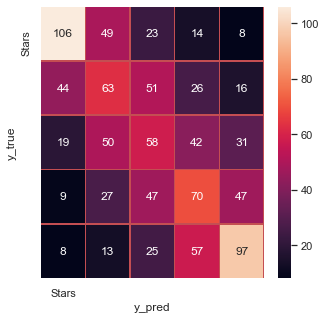

In [45]:
y_pred_nb =nb.predict(xtest)
confusion(ytest,y_pred_nb)
plt.show()

**Support Vector Classifier**

In [46]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
svc.score(xtest,ytest)

0.392

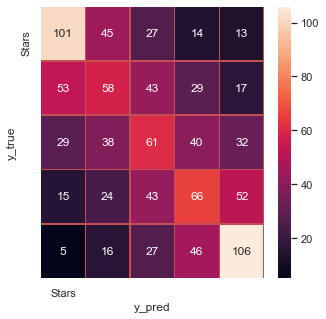

In [47]:
y_pred_scv=svc.predict(xtest)
confusion(ytest,y_pred_scv)

**Random Forest Classifier**

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))

acc:  0.396


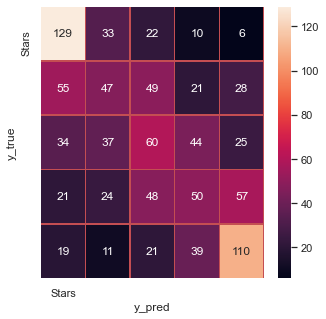

In [49]:
y_pred_rf=rf.predict(xtest)
confusion(ytest,y_pred_rf)

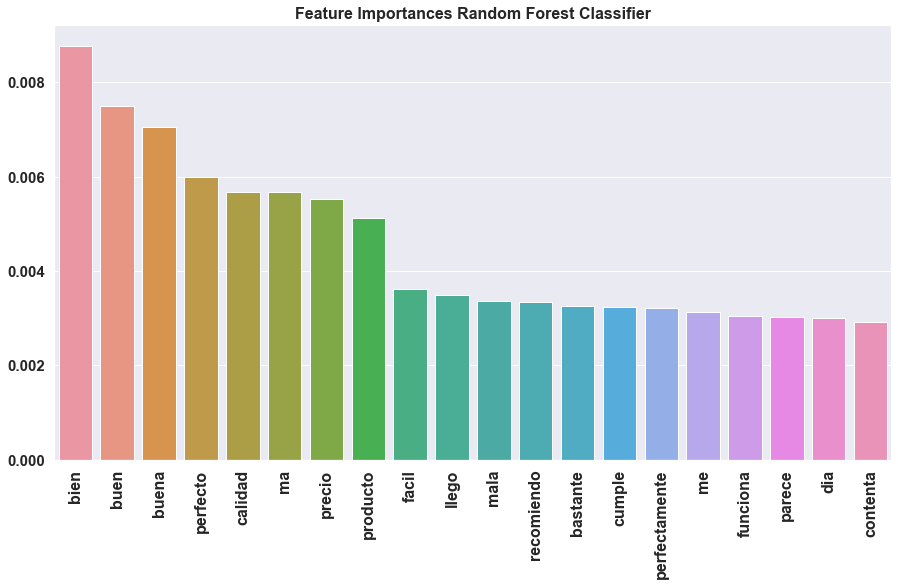

In [50]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances).set_title('Feature Importances Random Forest Classifier',
             fontsize=16, weight="bold")
plt.xticks(rotation = 90, fontsize=16, weight="bold")
plt.yticks( fontsize=15, weight="bold")
plt.show()

Al ejecutar los modelos y revisar las matrices de confusión es posible confirmar lo que indicaba al inicio de mi análisis respecto de la preminencia de valores neutrales. Los modelos son más precisos en los valores extremos (1, 5) y pierden eficacia cuando las calificaciones son intermedias.

#### Parte C - Investigación

Retomando el concepto de NPS (Net Promote Score) podemos traer la noción de que en esa escala se diferencian tres tipos de interacciones de los clientes frente a la calificación:

* Promotores
* Neutrales o Pasivos 
* Detractores 

Como en el EDA pudimos ver el dataset provisto tiene una división homogénea respecto a cada calificación, por lo que los valores intermedios (neutrales o pasivos) terminan siendo el 60% del dataset. 

Frente a esto y tomando como base la idea de NPS (cuyo cálculo excluye las calificaciones neutrales) pero cuidando no desechar tanta cantidad de datos se me ocurre agregar un criterio que reordene la escala de calificaciones dejando como neutrales solo las 3 estrellas. 

Además en este set de datos trabajaré con bigrams.

In [51]:
#Defino una función que categorice las calificaciones (stars) como Promotores, Detractores o Neutrales. Posteriormente agrego esa columna de Sntiment al Dataset.

def sentiment_stars (row):
    result = 'promotor'
    if int(row['stars']) <= 2:
        result = 'detractor'
    if int(row['stars']) == 3:
        result = 'neutral'
    return result

In [52]:
amazon_df ['sentiment'] = amazon_df.apply(sentiment_stars, axis=1)

In [53]:
amazon_df.head()

,stars,review_body,product_category,review_lemm,sentiment
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",wireless,malisimo grande demasiado aparatoso mal protec...,detractor
1,1,No he recibido el pedido no la devolución,apparel,recibido pedido devolucion,detractor
2,1,"Tengo que buscar otro sistema, este no funcion...",sports,buscar sistema funciona bien abrazadera lleva ...,detractor
3,1,Utilicé las brocas de menor diámetro y se me d...,home_improvement,utilice broca menor diametro doblaron varias m...,detractor
4,1,No me gusta su olor a viejo y aspecto malo,beauty,gusta olor viejo aspecto malo,detractor


In [54]:
amazon_df.tail()

,stars,review_body,product_category,review_lemm,sentiment
4995,5,Me ha encantado la cesta. Ha llegado impecable...,home,encantado cesta llegado impecable tamano util ...,promotor
4996,5,Desempeña su función correctamente,camera,desempena funcion correctamente,promotor
4997,5,Me ha encantado la diadema! Las flores son tal...,toy,encantado diadema flores tal vienen imagen ven...,promotor
4998,5,"A mi me gustan mucho las fundas TPU, ya que so...",wireless,gustan fundas tpu fundas normalmente finas col...,promotor
4999,5,El artículo ha cumplido con las expectativas q...,apparel,articulo cumplido expectativas deseaba,promotor


Como otra manera de refinar los datos, realizo una columna de Bigrams.

In [55]:
words_dataframe = basic_clean(''.join(str(amazon_df['review_lemm'].tolist())))

In [56]:
amazon_df ['bigrams_lemm'] = pd.Series(nltk.ngrams(words_dataframe, 2))

In [57]:
amazon_df.head()

,stars,review_body,product_category,review_lemm,sentiment,bigrams_lemm
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",wireless,malisimo grande demasiado aparatoso mal protec...,detractor,"(malisimo, grande)"
1,1,No he recibido el pedido no la devolución,apparel,recibido pedido devolucion,detractor,"(grande, demasiado)"
2,1,"Tengo que buscar otro sistema, este no funcion...",sports,buscar sistema funciona bien abrazadera lleva ...,detractor,"(demasiado, aparatoso)"
3,1,Utilicé las brocas de menor diámetro y se me d...,home_improvement,utilice broca menor diametro doblaron varias m...,detractor,"(aparatoso, mal)"
4,1,No me gusta su olor a viejo y aspecto malo,beauty,gusta olor viejo aspecto malo,detractor,"(mal, protector)"


In [58]:
promotores = amazon_df[amazon_df.sentiment=='promotor']

In [59]:
bigrams_count_prom = (pd.Series(promotores.bigrams_lemm).value_counts())[:5]
#bigrams_count_prom

In [60]:
neutrales = amazon_df[amazon_df.sentiment=='neutral']

In [61]:
bigrams_count_neutro = (pd.Series(neutrales.bigrams_lemm).value_counts())[:5]

In [62]:
detractor = amazon_df[amazon_df.sentiment=='detractor']

In [63]:
bigrams_count_det = (pd.Series(detractor.bigrams_lemm).value_counts())[:5]

Grafico los bigrams dentro de cada categorización de Bigrams

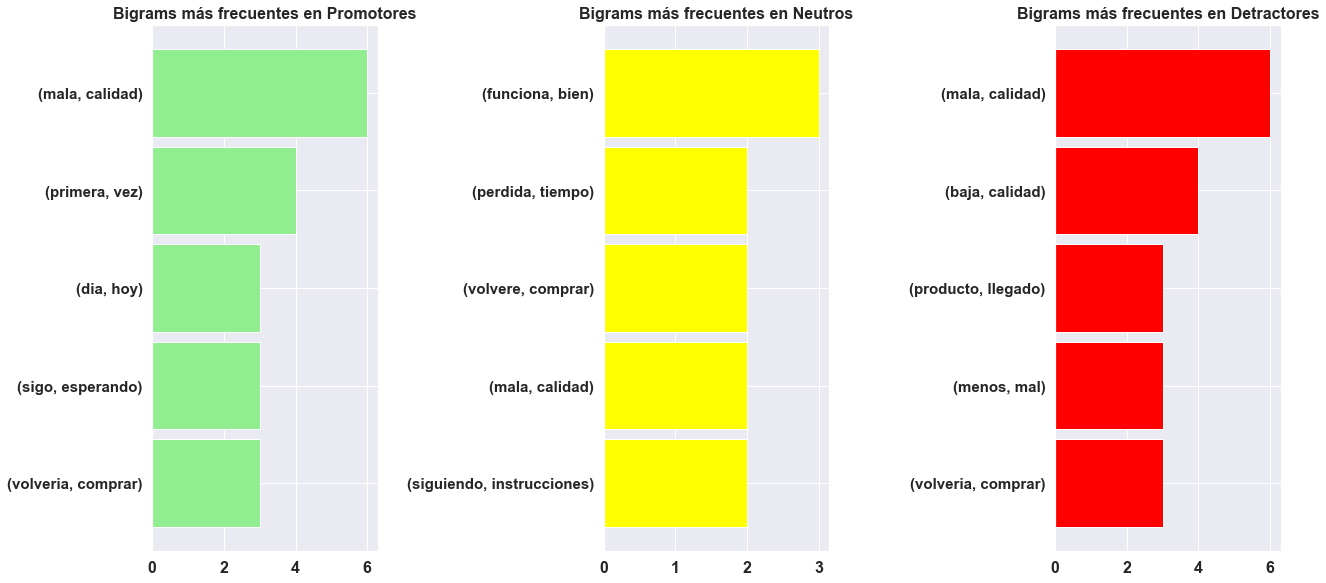

In [64]:
plt.figure(figsize=(40,8))
plt.grid()
plt.tight_layout()
plt.subplots_adjust(wspace = 1)


plt.subplot(1,3,1)
bigrams_count_prom.sort_values().plot.barh(color='lightgreen', width=.9, figsize=(16, 8))
plt.title('Bigrams más frecuentes en Promotores', fontsize=16, weight="bold")
plt.xticks( fontsize=16, weight="bold")
plt.yticks( fontsize=15, weight="bold")

plt.subplot(1,3,2)
bigrams_count_neutro.sort_values().plot.barh(color='yellow', width=.9, figsize=(16, 8))
plt.title('Bigrams más frecuentes en Neutros', fontsize=16, weight="bold")
plt.xticks( fontsize=16, weight="bold")
plt.yticks( fontsize=15, weight="bold")

plt.subplot(1,3,3)
bigrams_count_det.sort_values().plot.barh(color='red', width=.9, figsize=(16, 8))
plt.title('Bigrams más frecuentes en Detractores', fontsize=16, weight="bold")
plt.xticks( fontsize=16, weight="bold")
plt.yticks( fontsize=15, weight="bold")

plt.show()

El primer dato curioso (o podemos decir confuso) es que dentro de los bigrams principales tanto de Promotores como Detractores tenemos 'mala, calidad'.

Incorporo variables dummy para cada categoría de sentiment, categoría de producto y bigrams. Si bien esto aumentará la cantidad de variables, como se trata de un dataset de pocos datos (5k) no debería verse afectado el costo computacional de correr modelos con este set de datos.

In [65]:
product_category_dummy = pd.get_dummies(amazon_df['product_category'], prefix = 'product_category')
sentiment_dummy = pd.get_dummies(amazon_df['sentiment'], prefix = 'sentiment')
bigrams_dummy = pd.get_dummies(amazon_df['bigrams_lemm'], prefix = 'bigrams')

In [66]:
amazon_df = pd.concat([amazon_df, product_category_dummy], axis=1)
amazon_df = pd.concat([amazon_df, sentiment_dummy], axis=1)
amazon_df = pd.concat([amazon_df, bigrams_dummy], axis=1)

In [67]:
amazon_df.shape

(5000, 4811)

In [68]:
amazon_df.head()

,stars,review_body,product_category,review_lemm,sentiment,bigrams_lemm,product_category_apparel,product_category_automotive,product_category_baby_product,product_category_beauty,...,"bigrams_('wifi', 'pueden')","bigrams_('wifi', 'wifi')","bigrams_('window', 'segundos')","bigrams_('wl', 'producto')","bigrams_('x', 'q')","bigrams_('yendo', 'manos')","bigrams_('z', 'mapa')","bigrams_('zampa', 'vamos')","bigrams_('zas', 'apaga')","bigrams_('zona', 'visibles')"
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",wireless,malisimo grande demasiado aparatoso mal protec...,detractor,"(malisimo, grande)",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,No he recibido el pedido no la devolución,apparel,recibido pedido devolucion,detractor,"(grande, demasiado)",1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,"Tengo que buscar otro sistema, este no funcion...",sports,buscar sistema funciona bien abrazadera lleva ...,detractor,"(demasiado, aparatoso)",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Utilicé las brocas de menor diámetro y se me d...,home_improvement,utilice broca menor diametro doblaron varias m...,detractor,"(aparatoso, mal)",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,No me gusta su olor a viejo y aspecto malo,beauty,gusta olor viejo aspecto malo,detractor,"(mal, protector)",0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Saco la variable a predecir (stars) del dataset así como las variables categóricas, conservando solo las numéricas.

In [69]:
amazon_nostars = pd.DataFrame(amazon_df)

In [70]:
amazon_nostars.drop(['stars', 'product_category', 'sentiment', 'review_body', 'review_lemm', 'bigrams_lemm'], 
               axis=1, inplace = True)

In [71]:
amazon_nostars.head()

,product_category_apparel,product_category_automotive,product_category_baby_product,product_category_beauty,product_category_book,product_category_camera,product_category_digital_ebook_purchase,product_category_drugstore,product_category_electronics,product_category_furniture,...,"bigrams_('wifi', 'pueden')","bigrams_('wifi', 'wifi')","bigrams_('window', 'segundos')","bigrams_('wl', 'producto')","bigrams_('x', 'q')","bigrams_('yendo', 'manos')","bigrams_('z', 'mapa')","bigrams_('zampa', 'vamos')","bigrams_('zas', 'apaga')","bigrams_('zona', 'visibles')"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Elijo los datos y realizo el train_test_split para correr los mismos modelos ejecutados anteriormente (benchmark) y sumar un modelo más como XGBOOST (Classifier).

In [72]:
features_bg = amazon_nostars
labels = stars

In [73]:
from sklearn.model_selection import train_test_split
X_train_bg, X_test_bg, y_train_bg, y_test_bg = train_test_split(features_bg, labels, test_size=0.3, random_state=42)

In [74]:
nb_bg = MultinomialNB()
nb_bg.fit(X_train_bg,y_train_bg)
print("acc : ", nb_bg.score(X_test_bg,y_test_bg))

acc :  0.6046666666666667


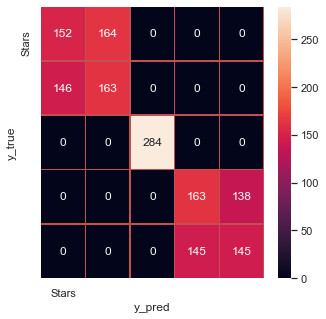

In [75]:
y_pred_bg =nb_bg.predict(X_test_bg)
confusion(y_test_bg,y_pred_bg)

In [76]:
rf_bg = RandomForestClassifier(n_estimators = 50, random_state=42)
rf_bg.fit(X_train_bg,y_train_bg)
print("acc: ",rf_bg.score(X_test_bg,y_test_bg))

acc:  0.6033333333333334


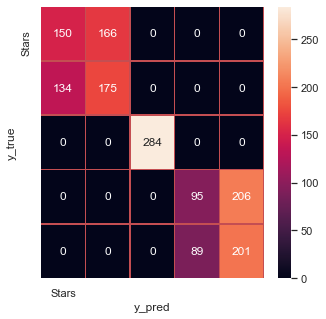

In [77]:
y_pred_rf_bg=rf_bg.predict(X_test_bg)
confusion(y_test_bg,y_pred_rf_bg)

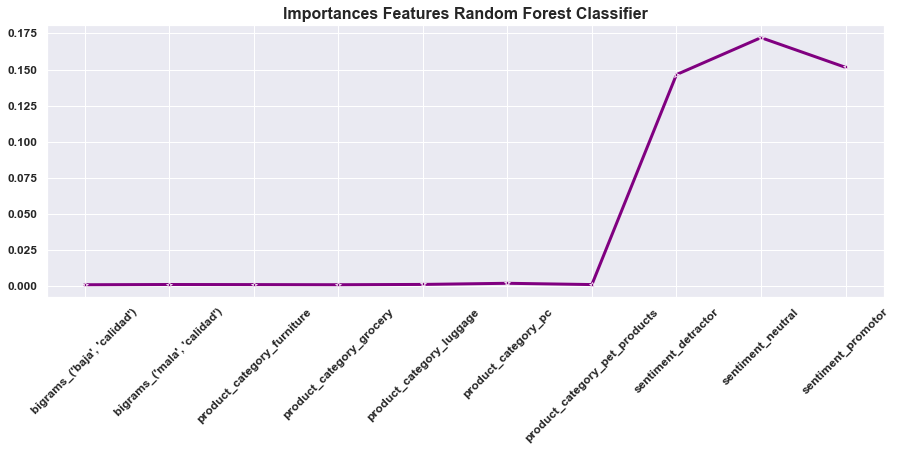

In [78]:
importances_rfbg = rf_bg.feature_importances_
columns_rfbg= X_train_bg.columns
indices_rfbg = np.argsort(importances_rfbg)[::-1]
indices_rfbg = indices_rfbg[:10]

plt.figure(figsize = (15,5))
plt.xticks(rotation = 45, fontsize=12, weight="bold" )
plt.yticks(fontsize=12, weight="bold" )
sns.lineplot(columns_rfbg[indices_rfbg], importances_rfbg[indices_rfbg], marker = '*', linewidth = 3, color ='purple').set_title('Importances Features Random Forest Classifier', fontsize=16, weight="bold")
plt.show()

In [79]:
from sklearn.svm import LinearSVC

svc_bg = LinearSVC(C = 10000000)
svc_bg.fit(X_train_bg,y_train_bg)
svc_bg.score(X_test_bg,y_test_bg)

C:\Users\cti22275\Miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.5866666666666667

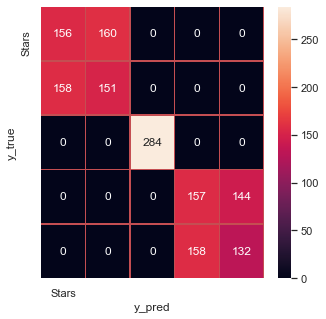

In [80]:
y_pred_bg_scv=svc_bg.predict(X_test_bg)
confusion(y_test_bg,y_pred_bg_scv)

En los modelos se observa además de una mejora en la exactitud (accuracy score), casi duplicando la efectividad, un reordenamiento de la predicción conforme al objetivo
planteado.

Se concentran los valores neutros (o sea son fácilmente identificables para el modelo) y se minimizan los errores en los valores extremos puros o inmediatamente anteriores. En esto tiene gran relevancia la clasificación de sentiment (como se puede ver en los gráficos lineales de feature importances) pero también la categoría a la que pertenece el producto y los bigrams aislados en la reseña. 

Otro punto importante es que no hay errores demasiado alejados entre los datos de prueba y los predecidos (confundir un 5 con un 1 como si se ve en las matrices de confusión de la primera ejecución del modelo). 


**XGBoost**

Decido probar este modelo porque lo utilicé en el Proyecto 2 y tiene buenos resultados con poca preparación de los datos (en las ejecuciones anteriores quizás podría haber mejorado la exactitud con una optimizació de hiperparámetros, aunque estoy satisfecha con el accuracy score logrado). 

La idea detrás del boosting es generar múltiples modelos de predicción “débiles” secuencialmente, y que cada uno de estos tome los resultados del modelo anterior, para generar un modelo más “fuerte”, con mejor poder predictivo y mayor estabilidad en sus resultados.

Para conseguir un modelo más fuerte a partir de estos modelos débiles, se emplea un algoritmo de optimización, este caso Gradient Descent (descenso de gradiente).

Cada modelo es comparado con el anterior. Si un nuevo modelo tiene mejores resultados, entonces se toma este como base para realizar modificaciones. Si, por el contrario, tiene peores resultados, se regresa al mejor modelo anterior y se modifica ese de una manera diferente.

Este proceso se repite hasta llegar a un punto en el que la diferencia entre modelos consecutivos es insignificante, lo cual nos indica que hemos encontrado el mejor modelo posible, o cuando se llega al número de iteraciones máximas definido por el usuario.

In [81]:
import xgboost as xgb

X = features_bg
y = labels


xtrain_xgb, xtest_xgb, ytrain_xgb, ytest_xgb=train_test_split(X, y, test_size=0.30)

In [82]:
xgbr = xgb.XGBClassifier(n_estimators = 50, max_depth = 47) 
print(xgbr)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=47,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)


In [83]:
 xgbr.fit(xtrain_xgb, ytrain_xgb)   

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=47,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
score = xgbr.score(xtrain_xgb, ytrain_xgb)  
print("Training score: ", score)

Training score:  0.6557142857142857


In [85]:
ypred_test_xgb = xgbr.predict(xtest_xgb)
ypred_train_xgb = xgbr.predict(xtrain_xgb)

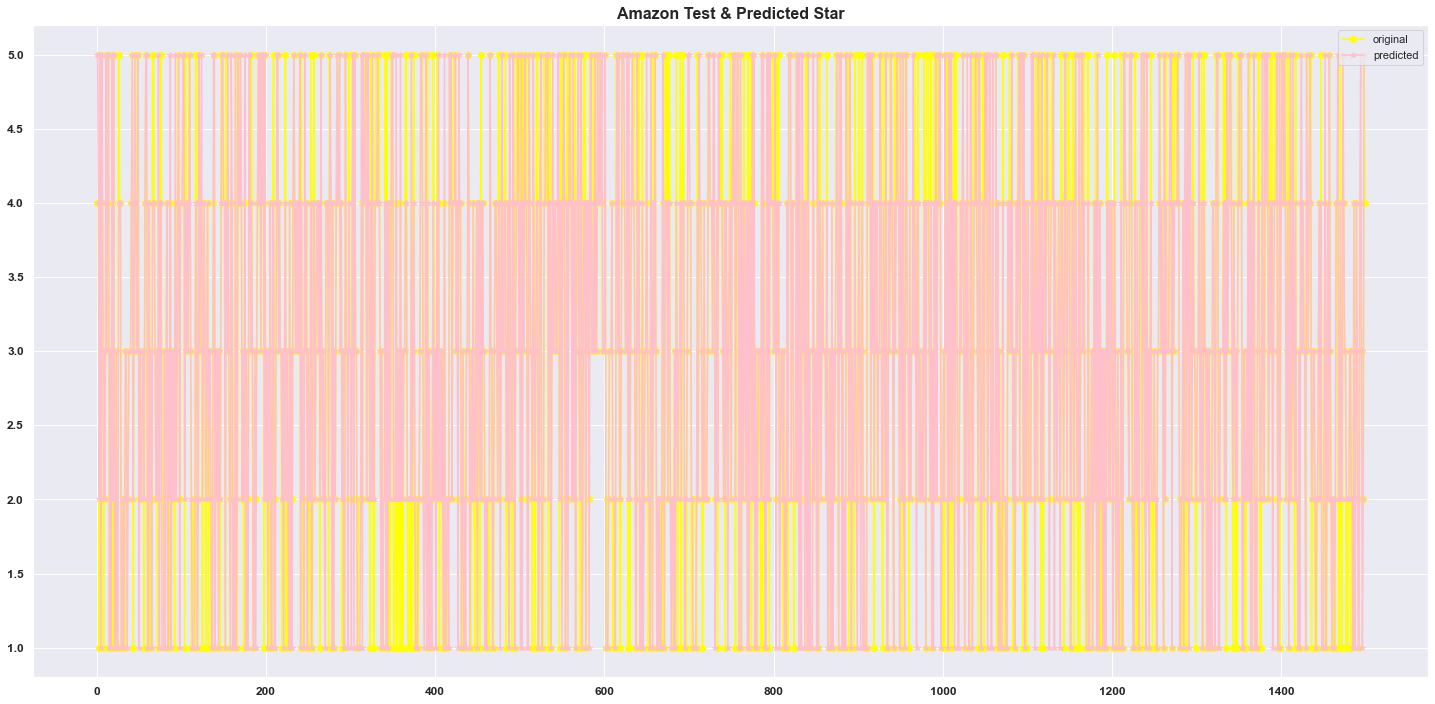

In [86]:
x_ax = range(len(ytest_xgb))
plt.figure(figsize = (25,12))
plt.plot(x_ax, ytest_xgb, label="original", marker = 'o', c='yellow') 
plt.plot(x_ax, ypred_test_xgb, label="predicted", marker = '*', c='pink')
plt.title("Amazon Test & Predicted Star", fontsize=16, weight="bold")
plt.yticks(fontsize=12, weight="bold" )
plt.xticks(fontsize=12, weight="bold" )

plt.legend()
plt.show()

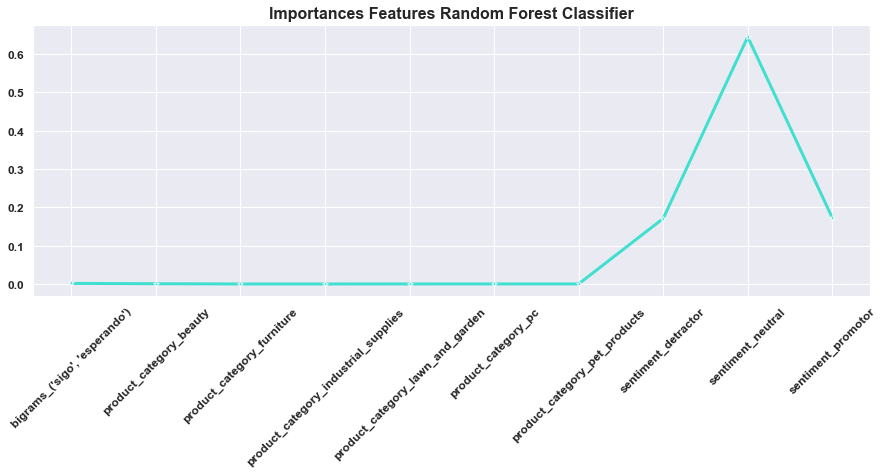

In [87]:
importances_xgb = xgbr.feature_importances_
columns_xgb= xtrain_xgb.columns
indices_xgb = np.argsort(importances_xgb)[::-1]
indices_xgb = indices_xgb[:10]

plt.figure(figsize = (15,5))
plt.yticks(fontsize=12, weight="bold" )
plt.xticks(rotation= 45,fontsize=12, weight="bold" )
sns.lineplot(columns_xgb[indices_xgb], importances_xgb[indices_xgb],marker = '*', linewidth = 3, color ='turquoise').set_title('Importances Features Random Forest Classifier', fontsize=16, weight="bold")
plt.show()


En los gráficos es posible ver un comportamiento parecido a lo que vemos en el feature importance o la matriz de confusión de los modelos benchmark, pero con una exactitud mejorada. 